# Autopilot 

This code helps in getting the steering angle of self driving car. The inspiraion is taken from [Udacity Self driving car](https://github.com/udacity/CarND-Behavioral-Cloning-P3) module as well [End to End Learning for Self-Driving Cars](https://devblogs.nvidia.com/deep-learning-self-driving-cars/) module from NVIDIA

The End to End Learning for Self-Driving Cars research paper can be found at (https://arxiv.org/abs/1604.07316)
This repository uses convnets to predict steering angle according to the road. 

1) Autopilot Version 1
2) [Autopilot Version 2](https://github.com/akshaybahadur21/Autopilot/tree/master/Autopilot_V2)


### Code Requirements
You can install Conda for python which resolves all the dependencies for machine learning.

##### pip install requirements.txt

### Description
An autonomous car (also known as a driverless car, self-driving car, and robotic car) is a vehicle that is capable of sensing its environment and navigating without human input. Autonomous cars combine a variety of techniques to perceive their surroundings, including radar, laser light, GPS, odometry, and computer vision. Advanced control systems interpret sensory information to identify appropriate navigation paths, as well as obstacles and relevant signage

## Autopilot V1 (Udacity Dataset based on Udacity Simulator)

### Dataset
You can get the dataset at [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)


## Autopilot V2 (NVIDIA Dataset based on real world)

### Dataset
Download the dataset at [here](https://github.com/SullyChen/driving-datasets) and extract into the repository folder


### References:
 
 - Mariusz Bojarski, Davide Del Testa, Daniel Dworakowski, Bernhard Firner, Beat Flepp, Prasoon Goyal, Lawrence D. Jackel, Mathew Monfort, Urs Muller, Jiakai Zhang, Xin Zhang, Jake Zhao, Karol Zieba. [End to End Learning for Self-Driving Cars](https://arxiv.org/abs/1604.07316)
 - [Behavioral Cloning Project](https://github.com/udacity/CarND-Behavioral-Cloning-P3) 
 - This implementation also took a lot of inspiration from the Sully Chen github repository: https://github.com/SullyChen/Autopilot-TensorFlow  







In [1]:
#Loading the dataset
from __future__ import division
import cv2
import os
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
from itertools import islice

In [2]:
DATA_FOLDER = 'driving_dataset'
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')

In [3]:
def preprocess(img):
    resized = cv2.resize((cv2.cvtColor(img, cv2.COLOR_RGB2HSV))[:, :, 1], (100, 100))
    return resized

In [6]:
def showData(x, label):
    img = plt.imread(x)
    pixels = np.array(img, dtype='uint8')

    pixels = pixels.reshape((256, 455,3))

    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

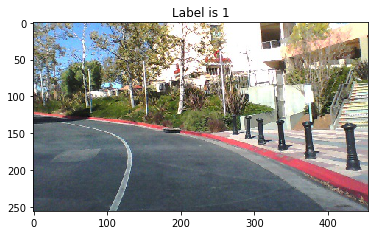

In [7]:
showData("F:\\projects\\SIT_Sample\\AutoPilot\\driving_dataset\\500.jpg",1)

In [8]:
def showData_HSV(x, label):
    img = plt.imread(x)
    img=preprocess(img)
    pixels = np.array(img, dtype='uint8')

    pixels = pixels.reshape((100, 100))

    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

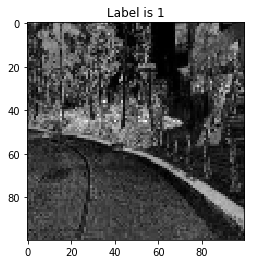

In [9]:
showData_HSV("F:\\projects\\SIT_Sample\\AutoPilot\\driving_dataset\\500.jpg",1)

In [10]:
def return_data():

    X = []
    y = []
    features = []

    with open(TRAIN_FILE) as fp:
        for line in islice(fp, LIMIT):
            path, angle = line.strip().split()
            full_path = os.path.join(DATA_FOLDER, path)
            X.append(full_path)
            # using angles from -pi to pi to avoid rescaling the atan in the network
            y.append(float(angle) * scipy.pi / 180)

    for i in range(len(X)):
        img = plt.imread(X[i])
        features.append(preprocess(img))

    features = np.array(features).astype('float32')
    labels = np.array(y).astype('float32')

    with open("features", "wb") as f:
        pickle.dump(features, f, protocol=4)
    with open("labels", "wb") as f:
        pickle.dump(labels, f, protocol=4)

In [11]:
LIMIT=None
return_data()

In [12]:
#Build the model
import numpy as np
from keras.layers import Dense, Activation, Flatten, Conv2D, Lambda
from keras.layers import MaxPooling2D, Dropout
from keras.utils import print_summary
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import pickle

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [13]:
def loadFromPickle():
    with open("features", "rb") as f:
        features = np.array(pickle.load(f))
    with open("labels", "rb") as f:
        labels = np.array(pickle.load(f))

    return features, labels

In [14]:
features, labels = loadFromPickle()

In [15]:
features, labels = shuffle(features, labels)
train_x, test_x, train_y, test_y = train_test_split(features, labels, random_state=0,
                                                    test_size=0.3)

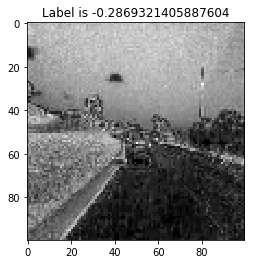

In [16]:
def showLoadedData(x, label):
    pixels = np.array(x, dtype='uint8')

    #pixels = pixels.reshape((100, 100))

    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()
showLoadedData(train_x[0],train_y[0])

In [17]:
train_x = train_x.reshape(train_x.shape[0], 100, 100, 1)
test_x = test_x.reshape(test_x.shape[0], 100, 100, 1)

In [21]:
def keras_model(image_x, image_y):
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=(image_x, image_y, 1)))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))


    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Dense(256))
    model.add(Dense(64))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss="mse")
    filepath = "Autopilot_10.h5"
    checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True)
    callbacks_list = [checkpoint]

    return model, callbacks_list

In [22]:
model, callbacks_list = keras_model(100, 100)
print_summary(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
activation_7 (Activation)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 25, 32)        0         
__________

In [ ]:
 model.fit(train_x, train_y, validation_data=(test_x, test_y), epochs=1, batch_size=32,
              callbacks=callbacks_list)

Train on 31784 samples, validate on 13622 samples
Epoch 1/3
 7168/31784 [=====>........................] - ETA: 11:09 - loss: 0.2994

In [20]:
#AutoPilot Application

In [23]:
import numpy as np
import cv2
from keras.models import load_model

In [24]:
model = load_model('Autopilot.h5')

In [25]:
def keras_predict(model, image):
    processed = keras_process_image(image)
    steering_angle = float(model.predict(processed, batch_size=1))
    steering_angle = steering_angle * 60
    return steering_angle


def keras_process_image(img):
    image_x = 100
    image_y = 100
    img = cv2.resize(img, (image_x, image_y))
    img = np.array(img, dtype=np.float32)
    img = np.reshape(img, (-1, image_x, image_y, 1))
    return img


steer = cv2.imread('steering_wheel_image.jpg', 0)
rows, cols = steer.shape
smoothed_angle = 0

In [30]:
cap = cv2.VideoCapture('test.mp4')
flag=0

In [31]:
while (cap.isOpened() and flag<1000):
    flag+=1
    ret, frame = cap.read()
    gray = cv2.resize((cv2.cvtColor(frame, cv2.COLOR_RGB2HSV))[:, :, 1], (100, 100))
    steering_angle = keras_predict(model, gray)
    print(steering_angle)
    cv2.imshow('frame', cv2.resize(frame, (600, 400), interpolation=cv2.INTER_AREA))
    smoothed_angle += 0.2 * pow(abs((steering_angle - smoothed_angle)), 2.0 / 3.0) * (
        steering_angle - smoothed_angle) / abs(
        steering_angle - smoothed_angle)
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), -smoothed_angle, 1)
    dst = cv2.warpAffine(steer, M, (cols, rows))
    cv2.imshow("steering wheel", dst)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

13.032190203666687
14.42494511604309
1.0335249826312065
4.296900182962418
13.871667981147766
11.831551194190979
14.828550517559052
14.585915207862854
17.563587427139282
11.97448343038559
11.420888900756836
1.5304858982563019
5.572136342525482
3.301248997449875
1.7982066795229912
5.672426372766495
-6.402662247419357
6.31350964307785
8.258461654186249
-1.8479807674884796
10.741829574108124
5.334801524877548
5.679456889629364
5.392049252986908
10.359971523284912
11.707188785076141
12.533150017261505
8.496724963188171
5.841348320245743
6.859226077795029
14.120817482471466
7.207578420639038
11.520423889160156
6.321292519569397
6.704029887914658
6.109139174222946
10.876301229000092
13.082537949085236
9.05613362789154
14.48703020811081
12.175887823104858
17.397653460502625
13.937010169029236
14.095138907432556
16.28585636615753
25.945855379104614
22.895396947860718
25.5101877450943
19.616382122039795
24.47292923927307
29.217756986618042
30.657670497894287
31.780951023101807
27.509526014328003